# LowProFool
## Adversarial examples generation on the german credit dataset

### Imports

In [201]:
# Misc
import random
import numpy as np
import pandas as pd
import tqdm
from tqdm import tqdm
from tqdm import tqdm_notebook
import math
import os
import time
import sys

In [202]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [203]:
# Sklearn
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [204]:
# Pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
# Keras 
import keras

In [205]:
# Helpers
from Adverse import lowProFool, deepfool
from Metrics import *

### Notebook config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


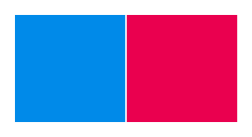

In [206]:
# Retina display
%config InlineBackend.figure_format ='retina'
pd.set_option('display.max_columns', 500)
tqdm.pandas()
np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

ccolors = ["#008ae9", "#ea004f"]
sns.set_palette(ccolors)
sns.palplot(sns.color_palette())

### Constants

In [207]:
SEED = 0
DATASET = 'credit-g'

### Fetch data from openml

In [208]:
def get_df(dataset):
    assert(dataset == 'credit-g')
    
    dataset = fetch_openml(dataset)
    target = 'target'
    df = pd.DataFrame(data= np.c_[dataset['data'], dataset[target]], columns= dataset['feature_names'] + [target])  

    # Renaming target for training later
    df[target] = df[target].apply(lambda x: 0.0 if x == 'bad' or x == 0.0 else 1.0)

    # Subsetting features to keep only continuous, discrete and ordered categorical
    feature_names = ['checking_status', 'duration', 'credit_amount',
                 'savings_status','employment','installment_commitment',
                 'residence_since','age','existing_credits','num_dependents',
                 'own_telephone','foreign_worker']

    df = df[feature_names + [target]]

    # Casting to float for later purpose
    df = df.astype(float)
    return df, target, feature_names

### Preprocess data

In [209]:
def normalize(df, target, feature_names, bounds):
    df_return = df.copy()
    
    # Makes sure target does not need scaling
    targets = np.unique(df[target].values)
    assert(len(targets == 2) and 0. in targets and 1. in targets)
    
    scaler = MinMaxScaler()
    X = df_return[feature_names]
    scaler.fit(X)    
    df_return[feature_names] = scaler.transform(X)
    
    lower_bounds = scaler.transform([bounds[0]])
    upper_bounds = scaler.transform([bounds[1]])

    return scaler, df_return, (lower_bounds[0], upper_bounds[0])

# 逆正規化
def denormalize(scaler, normalized_df, feature_names):
    """
    正規化されたデータフレームを元のスケールに戻します

    Parameters:
    -----------
    scaler : MinMaxScaler
        normalize関数で使用したscalerインスタンス
    normalized_df : pandas.DataFrame
        正規化されたデータフレーム
    feature_names : list
        正規化された特徴量の名前のリスト

    Returns:
    --------
    pandas.DataFrame
        元のスケールに戻したデータフレーム
    """
    df_return = normalized_df.copy()

    # 特徴量のみを逆変換
    X_normalized = df_return[feature_names]
    df_return[feature_names] = scaler.inverse_transform(X_normalized)

    return df_return

def get_weights(df, target, show_heatmap=False):
    def heatmap(cor):
        plt.figure(figsize=(8,6))
        sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
        plt.show()

    cor = df.corr()
    cor_target = abs(cor[target])

    weights = cor_target[:-1] #removing target WARNING ASSUMES TARGET IS LAST
    weights = weights / np.linalg.norm(weights)

    if show_heatmap:
        heatmap(cor)
            
    return weights.values

def balance_df(df):
    len_df_0, len_df_1 = len(df[df[target] == 0.]), len(df[df[target] == 1.])
    df_0 = df[df[target] == 0.].sample(min(len_df_0, len_df_1), random_state=SEED)
    df_1 = df[df[target] == 1.].sample(min(len_df_0, len_df_1), random_state=SEED)
    df = pd.concat((df_0, df_1))
    return df

def get_bounds():
    low_bounds = df_orig.min().values
    up_bounds = df_orig.max().values
    
    #removing target WARNING ASSUMES TARGET IS LAST
    low_bounds = low_bounds[:-1]
    up_bounds = up_bounds[:-1]
    
    return [low_bounds, up_bounds]

def split_train_test_valid():
    # Train test splits
    df_train, df_test = train_test_split(df, test_size=300, shuffle=True, random_state=SEED)
    df_test, df_valid = train_test_split(df_test, test_size=50, shuffle=True, random_state=SEED)
    
    return df_train, df_test, df_valid

### Training neural net

In [210]:
def get_model(conf, load=False):
    assert(conf['Dataset'] == 'credit-g')
    
    class GermanNet(nn.Module):
        def __init__(self, D_in, H, D_out):
            super(GermanNet, self).__init__()
            self.linear1 = torch.nn.Linear(D_in, H)
            self.linear2 = torch.nn.Linear(H, H)
            self.linear3 = torch.nn.Linear(H, D_out)
            self.relu = torch.nn.ReLU()
            self.softmax = torch.nn.Softmax(dim=-1)

        def forward(self, x):
            h1 = self.relu(self.linear1(x))
            h2 = self.relu(self.linear2(h1))
            h3 = self.relu(self.linear2(h2))
            h4 = self.relu(self.linear2(h3))
            h5 = self.relu(self.linear2(h4))
            h6 = self.relu(self.linear2(h5))
            a3 = self.linear3(h6)
            y = self.softmax(a3)
            return y

    def train(model, criterion, optimizer, X, y, N, n_classes):
        model.train()

        current_loss = 0
        current_correct = 0


        # Training in batches
        for ind in range(0, X.size(0), N):
            indices = range(ind, min(ind + N, X.size(0)) - 1) 
            inputs, labels = X[indices], y[indices]
            inputs = Variable(inputs, requires_grad=True)


            optimizer.zero_grad()

            output = model(inputs)
            _, indices = torch.max(output, 1) # argmax of output [[0.61, 0.12]] -> [0]
            # [[0, 1, 1, 0, 1, 0, 0]] -> [[1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0]]
            preds = torch.tensor(keras.utils.to_categorical(indices, num_classes=n_classes))

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            current_loss += loss.item()
            current_correct += (preds.int() == labels.int()).sum() /n_classes


        current_loss = current_loss / X.size(0)
        current_correct = current_correct.double() / X.size(0)    

        return preds, current_loss, current_correct.item()
    
    df = conf['TrainData']
    target = conf['Target']
    feature_names = conf['FeatureNames']
                        
    n_classes = len(np.unique(df[target]))
    X_train = torch.FloatTensor(df[feature_names].values)
    y_train = keras.utils.to_categorical(df[target], n_classes)
    y_train = torch.FloatTensor(y_train)

    D_in = X_train.size(1)
    D_out = y_train.size(1)

    epochs = 400
    batch_size = 100
    H = 100
    net = GermanNet(D_in, H, D_out)

    lr = 1e-4    
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    for epoch in range(epochs):
        preds, epoch_loss, epoch_acc = train(net, criterion, optimizer, X_train, y_train, batch_size, n_classes)     
        if (epoch % 50 == 0):
            print("> epoch {:.0f}\tLoss {:.5f}\tAcc {:.5f}".format(epoch, epoch_loss, epoch_acc))

    model_path = 'model_data/model.pth'
    # ディレクトリが存在しない場合は作成
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    torch.save(net.state_dict(), model_path)
    net.eval()
    
    return net

### Generate adversarial examples

In [211]:
def gen_adv(config, method):
    df_test = config['TestData']
    extra_cols = ['orig_pred', 'adv_pred', 'iters']    
    model = config['Model']
    weights = config['Weights']
    bounds = config['Bounds']
    maxiters = config['MaxIters']
    alpha = config['Alpha']
    lambda_ = config['Lambda']
    
    results = np.zeros((len(df_test), len(feature_names) + len(extra_cols)))    
            
    i = -1
    for _, row in tqdm_notebook(df_test.iterrows(), total=df_test.shape[0], desc="{}".format(method)):
        i += 1
        print(df_test.iloc[i].name)
        x_tensor = torch.FloatTensor(row[config['FeatureNames']])   
        
        if method == 'LowProFool':
            orig_pred, adv_pred, x_adv, loop_i = lowProFool(x_tensor, model, weights, bounds,
                                                             maxiters, alpha, lambda_)
        elif method == 'Deepfool':
            orig_pred, adv_pred, x_adv, loop_i = deepfool(x_tensor, model, maxiters, alpha,
                                                          bounds, weights=[])
        else:
            raise Exception("Invalid method", method)
        results[i] = np.concatenate((x_adv, [orig_pred, adv_pred, loop_i]), axis=0)
        
    return pd.DataFrame(results, index=df_test.index, columns = feature_names + extra_cols)

# 実行開始

In [212]:
# Load initial dataset
df_orig, target, feature_names = get_df(DATASET)

# Balance dataset classes
df = balance_df(df_orig)

# Compute the bounds for clipping
bounds = get_bounds()

# Normalize the data
scaler, df, bounds = normalize(df, target, feature_names, bounds)

# Compute the weihts modelizing the expert's knowledge
weights = get_weights(df, target)

# Split df into train/test/valid
df_train, df_test, df_valid = split_train_test_valid()

# Build experimenation config
config = {'Dataset'     : 'credit-g',
         'MaxIters'     : 20000,
         'Alpha'        : 0.001,
         'Lambda'       : 8.5,
         'TrainData'    : df_train,
         'TestData'     : df_test,
         'ValidData'    : df_valid,
         'Scaler'       : scaler,
         'FeatureNames' : feature_names,
         'Target'       : target,
         'Weights'      : weights,
         'Bounds'       : bounds}

# Train neural network
model = get_model(config)
config['Model'] = model

# Compute accuracy on test set
y_true = df_test[target]
x_test = torch.FloatTensor(df_test[feature_names].values)
y_pred = model(x_test)
y_pred = np.argmax(y_pred.detach().numpy(), axis=1)
print("Accuracy score on test data", accuracy_score(y_true, y_pred))
    
# Sub sample
config['TestData'] = config['TestData'].sample(n=10, random_state = SEED)

# Generate adversarial examples
df_adv_lpf = gen_adv(config, 'LowProFool')
df_adv_df = gen_adv(config, 'Deepfool')
config['AdvData'] = {'LowProFool' : df_adv_lpf, 'Deepfool' : df_adv_df}

# Compute metrics
list_metrics = {'SuccessRate' : True,
                'iter_means': False,
                'iter_std': False,
                'normdelta_median': False,
                'normdelta_mean': True,
                'n_std': True,
                'weighted_median': False,
                'weighted_mean': True,
                'w_std': True,
                'mean_dists_at_org': False,
                'median_dists_at_org': False,
                'mean_dists_at_tgt': False,
                'mean_dists_at_org_weighted': True,
                'mdow_std': True,
                'median_dists_at_org_weighted': False,
                'mean_dists_at_tgt_weighted': True,
                'mdtw_std': True,
                'prop_same_class_arg_org': False,
                'prop_same_class_arg_adv': False}

all_metrics = get_metrics(config, list_metrics)
all_metrics = pd.DataFrame(all_metrics, columns=['Method'] + [k for k, v in list_metrics.items() if v])
all_metrics

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/datasets/openml.py:305: UserWarning: Multiple active versions of the dataset matching the name credit-g exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))


> epoch 0	Loss 0.00693	Acc 0.47333
> epoch 50	Loss 0.00651	Acc 0.71333
> epoch 100	Loss 0.00515	Acc 0.73333
> epoch 150	Loss 0.00485	Acc 0.75000
> epoch 200	Loss 0.00460	Acc 0.76667
> epoch 250	Loss 0.00431	Acc 0.78667
> epoch 300	Loss 0.00394	Acc 0.82333
> epoch 350	Loss 0.00352	Acc 0.85333
Accuracy score on test data 0.724


685
output_prod [0.77132314 0.22867687]
727
output_prod [0.26397896 0.736021  ]
30
output_prod [0.81156796 0.18843204]
376
output_prod [0.87091416 0.12908578]
66
output_prod [0.76376146 0.23623855]
965
output_prod [0.16905499 0.83094496]
963
output_prod [0.79587513 0.20412493]
61
output_prod [0.90284866 0.09715136]
282
output_prod [0.94506395 0.05493605]
268
output_prod [0.80196166 0.1980383 ]


685
727
30
376
66
965
963
61
282
268


,Method,SuccessRate,normdelta_mean,n_std,weighted_mean,w_std,mean_dists_at_org_weighted,mdow_std,mean_dists_at_tgt_weighted,mdtw_std
0,LowProFool,1.0,0.371826,0.351785,0.044444,0.022818,0.214625,0.085894,0.212183,0.087536
1,Deepfool,1.0,0.198404,0.107955,0.082179,0.057259,0.214625,0.085894,0.212604,0.089857


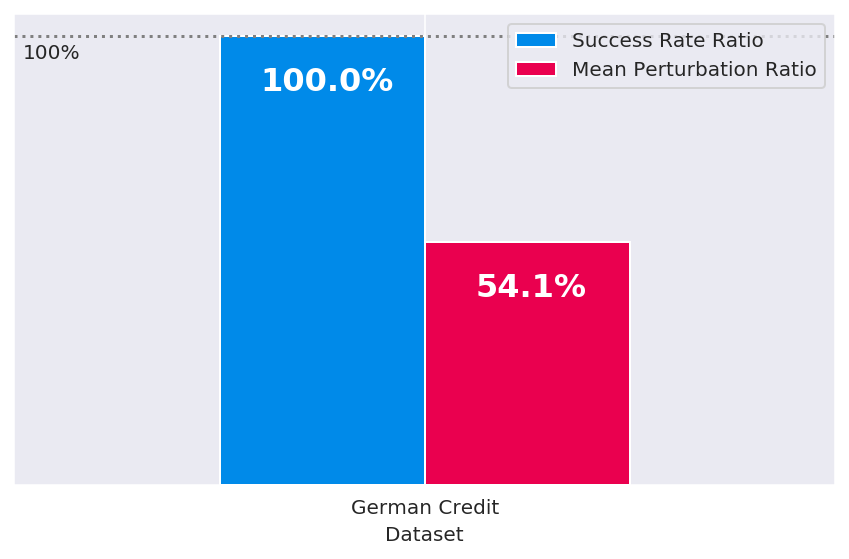

In [213]:
plot_ratios = []

m_lpf = all_metrics[all_metrics.Method == 'LowProFool']
m_df = all_metrics[all_metrics.Method =='Deepfool']

sr = m_lpf.SuccessRate.values / m_df.SuccessRate.values 
wm =  m_lpf.weighted_mean.values / m_df.weighted_mean.values 

plot_ratios.append([100*sr[0], 100*wm[0]])
plot_ratios = pd.DataFrame(plot_ratios, columns=['Success Rate Ratio', 'Mean Perturbation Ratio'])
plot_ratios['Dataset'] = 'German Credit'

f = plt.figure()
ax = plt.axes()
plot_ratios.plot(x='Dataset', kind='bar', legend=True, ax=ax)

for i, v in enumerate(plot_ratios['Success Rate Ratio'].values):
    ax.text(i - 0.2, v - 12 , str(v.round(1)) + '%', fontsize=16, color='white', weight='bold')
for i, v in enumerate(plot_ratios['Mean Perturbation Ratio'].values):
    ax.text(i + 0.062, v - 12, str(v.round(1)) + '%', fontsize=16, color='white', weight='bold')

plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center')
ax.axhline(100, ls=':', c='grey')
ax.text(-0.49, 100 - 5, '100%')


ax.set_yticks([])
plt.tight_layout()
plt.show()

### CSV出力

In [214]:
# 逆正規化
df_adv_lpf = denormalize(scaler, df_adv_lpf, feature_names=feature_names)
# lowprofool
df_adv_lpf.to_csv('data/lowprofool_propose1.csv')

# 逆正規化
df_adv_df = denormalize(scaler, df_adv_df, feature_names=feature_names)
# deepfool
df_adv_df.to_csv('data/deepfool_propose1.csv')

In [215]:
df_orig = pd.read_csv('data/df_orig.csv')
df_adv_lpf = pd.read_csv('data/lowprofool_propose1.csv')
df_adv_df = pd.read_csv('data/deepfool_propose1.csv')

In [216]:
arrs = [685, 727, 30, 376, 66, 965, 963, 61, 282, 268]

for i in arrs:
    orig_row = df_orig[df_orig['Unnamed: 0'] == i].copy()
    adv_lpf_row = df_adv_lpf[df_adv_lpf['Unnamed: 0'] == i].copy()
    adv_df_row = df_adv_df[df_adv_df['Unnamed: 0'] == i].copy()
    
    # Rename columns to match the original format
    orig_row.columns = [col if col != 'Unnamed: 0' else 'id' for col in orig_row.columns]
    adv_lpf_row.columns = [col if col != 'Unnamed: 0' else 'id' for col in adv_lpf_row.columns]
    adv_df_row.columns = [col if col != 'Unnamed: 0' else 'id' for col in adv_df_row.columns]
    
    # Combine rows into a single DataFrame
    combined_df = pd.concat([orig_row, adv_lpf_row, adv_df_row], keys=['orig', 'adv_lpf', 'adv_df']).reset_index(level=0).rename(columns={'level_0': 'type'})
    
    # Save the DataFrame as df_output_{id}
    globals()[f'df_output_{i}'] = combined_df

# Example to access one of the generated DataFrames
df_output_685

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,type,adv_pred,age,checking_status,credit_amount,duration,employment,existing_credits,foreign_worker,id,installment_commitment,iters,num_dependents,orig_pred,own_telephone,residence_since,savings_status,target
685,orig,NaN,34.000000,3.000000,6527.000000,60.000000,2.000000,1.000000,0.0,685,4.0,NaN,2.0,NaN,1.000000,4.000000,4.000000,1.0
0,adv_lpf,0.0,35.464986,2.991792,7558.809058,63.735689,1.683286,1.182069,0.0,685,4.0,58.0,2.0,1.0,0.884602,3.915949,3.919594,NaN
0,adv_df,0.0,35.177843,2.960790,7773.674275,66.380614,1.693357,1.106158,0.0,685,4.0,196.0,2.0,1.0,0.931056,3.953466,3.931557,NaN


In [217]:
df_output_727

,type,adv_pred,age,checking_status,credit_amount,duration,employment,existing_credits,foreign_worker,id,installment_commitment,iters,num_dependents,orig_pred,own_telephone,residence_since,savings_status,target
727,orig,NaN,25.000000,0.000000,1882.000000,18.000000,2.000000,2.000000,0.000000,727,4.000000,NaN,1.0,NaN,0.000000,4.000000,0.000000,0.0
1,adv_lpf,1.0,24.739769,0.115510,1968.785383,6.662109,2.313256,1.766320,0.128808,727,3.834479,57.0,1.0,0.0,0.106379,3.901645,0.000000,NaN
1,adv_df,1.0,24.556589,0.282744,1982.500608,6.530210,2.366636,1.844905,0.100574,727,3.850910,263.0,1.0,0.0,0.073656,3.927602,0.043836,NaN


In [218]:
df_output_30

,type,adv_pred,age,checking_status,credit_amount,duration,employment,existing_credits,foreign_worker,id,installment_commitment,iters,num_dependents,orig_pred,own_telephone,residence_since,savings_status,target
30,orig,NaN,36.000000,1.00000,1913.000000,18.000000,1.000000,1.000000,0.0,30,3.000000,NaN,1.0,NaN,1.000000,3.000000,3.000000,1.0
2,adv_lpf,0.0,35.513802,0.96772,4037.802756,26.568851,0.873868,1.249930,0.0,30,2.841088,38.0,1.0,1.0,0.972360,2.914505,2.842251,NaN
2,adv_df,0.0,36.096614,0.91190,3933.172527,27.621166,0.901475,1.188365,0.0,30,2.889593,223.0,1.0,1.0,0.983179,2.933217,2.853574,NaN


### int型に変換

In [219]:
arrs = [685, 727, 30, 376, 66, 965, 963, 61, 282, 268]

for i in arrs:
    orig_row = df_orig[df_orig['Unnamed: 0'] == i].copy()
    adv_lpf_row = df_adv_lpf[df_adv_lpf['Unnamed: 0'] == i].copy()
    adv_df_row = df_adv_df[df_adv_df['Unnamed: 0'] == i].copy()
    
    # Rename columns to match the original format
    orig_row.columns = [col if col != 'Unnamed: 0' else 'id' for col in orig_row.columns]
    adv_lpf_row.columns = [col if col != 'Unnamed: 0' else 'id' for col in adv_lpf_row.columns]
    adv_df_row.columns = [col if col != 'Unnamed: 0' else 'id' for col in adv_df_row.columns]
    
    # Combine rows into a single DataFrame
    combined_df = pd.concat([orig_row, adv_lpf_row, adv_df_row], keys=['orig', 'adv_lpf', 'adv_df']).reset_index(level=0).rename(columns={'level_0': 'type'})
    
    # Round and convert to int
    combined_df.loc[:, combined_df.columns != 'type'] = combined_df.loc[:, combined_df.columns != 'type'].fillna(0).round().astype(int)
    
    # Save the DataFrame as df_output_{id}
    globals()[f'df_output_i_{i}'] = combined_df

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [220]:
df_output_i_685

,type,adv_pred,age,checking_status,credit_amount,duration,employment,existing_credits,foreign_worker,id,installment_commitment,iters,num_dependents,orig_pred,own_telephone,residence_since,savings_status,target
685,orig,0,34,3,6527,60,2,1,0,685,4,0,2,0,1,4,4,1
0,adv_lpf,0,35,3,7559,64,2,1,0,685,4,58,2,1,1,4,4,0
0,adv_df,0,35,3,7774,66,2,1,0,685,4,196,2,1,1,4,4,0


In [221]:
df_output_i_727

,type,adv_pred,age,checking_status,credit_amount,duration,employment,existing_credits,foreign_worker,id,installment_commitment,iters,num_dependents,orig_pred,own_telephone,residence_since,savings_status,target
727,orig,0,25,0,1882,18,2,2,0,727,4,0,1,0,0,4,0,0
1,adv_lpf,1,25,0,1969,7,2,2,0,727,4,57,1,0,0,4,0,0
1,adv_df,1,25,0,1983,7,2,2,0,727,4,263,1,0,0,4,0,0


In [222]:
df_output_i_30

,type,adv_pred,age,checking_status,credit_amount,duration,employment,existing_credits,foreign_worker,id,installment_commitment,iters,num_dependents,orig_pred,own_telephone,residence_since,savings_status,target
30,orig,0,36,1,1913,18,1,1,0,30,3,0,1,0,1,3,3,1
2,adv_lpf,0,36,1,4038,27,1,1,0,30,3,38,1,1,1,3,3,0
2,adv_df,0,36,1,3933,28,1,1,0,30,3,223,1,1,1,3,3,0


In [231]:
df_output_i_376

,type,adv_pred,age,checking_status,credit_amount,duration,employment,existing_credits,foreign_worker,id,installment_commitment,iters,num_dependents,orig_pred,own_telephone,residence_since,savings_status,target
376,orig,0,34,3,2320,18,0,2,0,376,2,0,1,0,0,3,0,1
3,adv_lpf,0,34,3,2433,18,0,2,0,376,2,9,1,1,0,3,0,0
3,adv_df,0,34,3,2460,19,0,2,0,376,2,23,1,1,0,3,0,0


In [232]:
df_output_i_66

,type,adv_pred,age,checking_status,credit_amount,duration,employment,existing_credits,foreign_worker,id,installment_commitment,iters,num_dependents,orig_pred,own_telephone,residence_since,savings_status,target
66,orig,0,29,3,2171,12,1,1,0,66,2,0,1,0,0,2,0,1
4,adv_lpf,0,27,3,2603,14,1,1,0,66,2,28,1,1,0,2,0,0
4,adv_df,0,27,3,2567,16,1,1,0,66,2,89,1,1,0,2,0,0


In [233]:
df_output_i_965

,type,adv_pred,age,checking_status,credit_amount,duration,employment,existing_credits,foreign_worker,id,installment_commitment,iters,num_dependents,orig_pred,own_telephone,residence_since,savings_status,target
965,orig,0,26,1,1715,30,2,1,0,965,4,0,1,0,0,1,4,1
5,adv_lpf,1,24,1,1549,27,2,1,0,965,4,70,1,0,0,1,4,0
5,adv_df,1,25,1,1597,25,2,1,0,965,4,145,1,0,0,1,4,0


In [234]:
df_output_i_963

,type,adv_pred,age,checking_status,credit_amount,duration,employment,existing_credits,foreign_worker,id,installment_commitment,iters,num_dependents,orig_pred,own_telephone,residence_since,savings_status,target
963,orig,0,35,3,2397,24,4,2,0,963,3,0,1,0,1,2,2,0
6,adv_lpf,0,37,3,3473,27,4,2,0,963,2,87,1,1,1,1,2,0
6,adv_df,0,37,3,5715,37,4,2,0,963,3,382,1,1,1,2,2,0


In [235]:
df_output_i_61

,type,adv_pred,age,checking_status,credit_amount,duration,employment,existing_credits,foreign_worker,id,installment_commitment,iters,num_dependents,orig_pred,own_telephone,residence_since,savings_status,target
61,orig,0,50,1,1537,15,4,2,0,61,4,0,1,0,1,4,4,1
7,adv_lpf,0,53,1,1545,15,4,1,0,61,4,136,2,1,1,3,4,0
7,adv_df,0,53,0,3522,28,4,2,0,61,4,439,1,1,1,4,4,0


In [236]:
df_output_i_282

,type,adv_pred,age,checking_status,credit_amount,duration,employment,existing_credits,foreign_worker,id,installment_commitment,iters,num_dependents,orig_pred,own_telephone,residence_since,savings_status,target
282,orig,0,49,2,1445,18,3,1,0,282,4,0,1,0,0,4,4,1
8,adv_lpf,0,50,2,1215,18,3,1,0,282,4,79,2,1,0,4,4,0
8,adv_df,0,56,1,2144,21,3,1,0,282,4,318,1,1,0,4,4,0


In [237]:
df_output_i_268

,type,adv_pred,age,checking_status,credit_amount,duration,employment,existing_credits,foreign_worker,id,installment_commitment,iters,num_dependents,orig_pred,own_telephone,residence_since,savings_status,target
268,orig,0,45,0,8978,14,4,1,1,268,1,0,1,0,1,4,0,0
9,adv_lpf,0,48,0,10264,19,4,1,1,268,1,47,1,1,1,4,0,0
9,adv_df,0,48,0,10324,21,4,1,1,268,1,186,1,1,1,4,0,0


### 確率の出力

In [223]:
none, target, feature_names = get_df(DATASET)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/datasets/openml.py:305: UserWarning: Multiple active versions of the dataset matching the name credit-g exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))


In [224]:
df_orig_int = df_orig.copy()
scaler, df_orig_int, bounds = normalize(df_orig_int, target, feature_names, bounds)
df_orig_int_test = torch.FloatTensor(df_orig_int[feature_names].values)
y_pred_orig = model(df_orig_int_test)
print(y_pred_orig)

tensor([[0.2167, 0.7833],
        [0.9860, 0.0140],
        [0.1227, 0.8773],
        ...,
        [0.0043, 0.9957],
        [0.9666, 0.0334],
        [0.9875, 0.0125]], grad_fn=<SoftmaxBackward>)


In [225]:
df_orig_filltered = df_orig[df_orig['Unnamed: 0'].isin(arrs)].copy()
scaler, df_orig_filltered, bounds = normalize(df_orig_filltered, target, feature_names, bounds)
df_orig_test_filltered = torch.FloatTensor(df_orig_filltered[feature_names].values)
y_pred_orig_filltered = model(df_orig_test_filltered)
print(y_pred_orig_filltered)

tensor([[0.0629, 0.9371],
        [0.0722, 0.9278],
        [0.1792, 0.8208],
        [0.6160, 0.3840],
        [0.3223, 0.6777],
        [0.5665, 0.4335],
        [0.6830, 0.3170],
        [0.9628, 0.0372],
        [0.0653, 0.9347],
        [0.6496, 0.3504]], grad_fn=<SoftmaxBackward>)


In [226]:
df_adv_lpf = df_adv_lpf.copy()
scaler, df_adv_lpf, bounds = normalize(df_adv_lpf, 'orig_pred', feature_names, bounds)
df_adv_lpf_test = torch.FloatTensor(df_adv_lpf[feature_names].values)
y_pred_lpf = model(df_adv_lpf_test)
print(y_pred_lpf)

tensor([[0.8407, 0.1593],
        [0.6284, 0.3716],
        [0.7714, 0.2286],
        [0.7099, 0.2901],
        [0.5858, 0.4142],
        [0.4560, 0.5440],
        [0.7940, 0.2060],
        [0.9723, 0.0277],
        [0.9729, 0.0271],
        [0.8423, 0.1577]], grad_fn=<SoftmaxBackward>)


In [227]:
df_adv_df = df_adv_df.copy()
scaler, df_adv_df, bounds = normalize(df_adv_df, 'orig_pred', feature_names, bounds)
df_adv_df_test = torch.FloatTensor(df_adv_df[feature_names].values)
y_pred_df = model(df_adv_df_test)
print(y_pred_df)

tensor([[0.8080, 0.1920],
        [0.6678, 0.3322],
        [0.6922, 0.3078],
        [0.7147, 0.2853],
        [0.5400, 0.4600],
        [0.4477, 0.5523],
        [0.8641, 0.1359],
        [0.6303, 0.3697],
        [0.8304, 0.1696],
        [0.8585, 0.1415]], grad_fn=<SoftmaxBackward>)


In [228]:
# Filter the DataFrame
df_orig_filltered = df_orig[df_orig['Unnamed: 0'].isin(arrs)].copy()

# Round and convert to int
df_orig_filltered_int = df_orig_filltered.round().astype(int)

# Normalize the data
scaler, df_orig_int_filltered, bounds = normalize(df_orig_filltered_int, target, feature_names, bounds)
df_orig_int_test_filltered = torch.FloatTensor(df_orig_int_filltered[feature_names].values)
y_pred_orig_filltered = model(df_orig_int_test_filltered)
print(y_pred_orig_filltered)

tensor([[0.0629, 0.9371],
        [0.0722, 0.9278],
        [0.1792, 0.8208],
        [0.6160, 0.3840],
        [0.3223, 0.6777],
        [0.5665, 0.4335],
        [0.6830, 0.3170],
        [0.9628, 0.0372],
        [0.0653, 0.9347],
        [0.6496, 0.3504]], grad_fn=<SoftmaxBackward>)


In [229]:
df_adv_lpf = df_adv_lpf[df_adv_lpf['Unnamed: 0'].isin(arrs)].copy()

# Round and convert to int
df_adv_lpf_int = df_adv_lpf.round().astype(int)

scaler, df_adv_lpf_int, bounds = normalize(df_adv_lpf_int, 'orig_pred', feature_names, bounds)


df_adv_lpf_int_test = torch.FloatTensor(df_adv_lpf_int[feature_names].values)
y_pred_lpf = model(df_adv_lpf_int_test)
print(y_pred_lpf)

tensor([[0.9865, 0.0135],
        [0.5296, 0.4704],
        [0.0419, 0.9581],
        [0.5297, 0.4703],
        [0.3375, 0.6625],
        [0.6974, 0.3026],
        [0.4184, 0.5816],
        [0.9447, 0.0553],
        [0.7723, 0.2277],
        [0.4684, 0.5316]], grad_fn=<SoftmaxBackward>)


In [230]:
df_adv_df = df_adv_df[df_adv_df['Unnamed: 0'].isin(arrs)].copy()

# Round and convert to int
df_adv_df_int = df_adv_df.round().astype(int)

scaler, df_adv_df_int, bounds = normalize(df_adv_df_int, 'orig_pred', feature_names, bounds)

df_adv_df_test = torch.FloatTensor(df_adv_df_int[feature_names].values)
y_pred_df = model(df_adv_df_test)
print(y_pred_df)

tensor([[0.9865, 0.0135],
        [0.5296, 0.4704],
        [0.0419, 0.9581],
        [0.5297, 0.4703],
        [0.3375, 0.6625],
        [0.6974, 0.3026],
        [0.8696, 0.1304],
        [0.2431, 0.7569],
        [0.0475, 0.9525],
        [0.4684, 0.5316]], grad_fn=<SoftmaxBackward>)
